# ALGORITHMES DE DETECTION DU WHEEL-SPINNING    *(EVIDENCE B)* : NOTEBOOK EXPERIMENTAL SUR L'APPLICATION ADAPTIV-FRACTION

## Modules

Gestion de répertoires systèmes :

In [1]:
import os

Analyse de données :

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Preprocessing des données :

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Machine learning (Deep learning) :

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences 

Teste si mon GPU est actif pour tensorflow :

In [5]:
import tensorflow as tf
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Metriques :

In [6]:
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score
from tensorflow.keras.metrics import Recall, Precision

## Récupération des données

Fonction de récupération automatique des donnéees :

In [7]:
DUMP_ROOT = "https://raw.githubusercontent.com/EvidenceB/wheel-spinning/main/Datasets/dump.csv"
GITHUB_TOKEN = "token=ANA3ZLFD4DLR3I3D454JAO3BH2JGC"
DUMP_URL = DUMP_ROOT + "?" + GITHUB_TOKEN

def fetch_data(dump_url = DUMP_URL):
    
    if not os.path.isdir("Datasets"):
        os.makedirs("Datasets")
        df = pd.read_csv(dump_url)
        df.to_csv("Datasets/dump.csv", index=False)
        return df
        
    else:
        return pd.read_csv("Datasets/dump.csv")

Récupération des données et affichage :

In [8]:
df = fetch_data()

Affichons lui ses cinq premières observations :

In [9]:
df.head()

,student_id,homepage,exercise_id,score,duration,activity_id,objective_id,module_id,ts
0,4b2a858ec19a4062868f92ce0ff7c8bb,http://xapiressource.prod.evidenceb-services.c...,1a705a1f-71e7-4262-af24-e8fce1259d19,1.0,15,d48a123d-827c-4b50-8102-62361be549ba,8f6c4c01-734e-4f69-8e7a-fe5c066fe342,1b0ed844-31bb-4fc6-94e8-2df42b78271e,2021-05-19 14:10:38.859000+00:00
1,e5434ff321954840a17283fa7033dd04,http://xapiressource.prod.evidenceb-services.c...,1a705a1f-71e7-4262-af24-e8fce1259d19,1.0,15,d48a123d-827c-4b50-8102-62361be549ba,8f6c4c01-734e-4f69-8e7a-fe5c066fe342,1b0ed844-31bb-4fc6-94e8-2df42b78271e,2021-05-19 14:10:38.859000+00:00
2,d3b148ffa8b64d50a443ccf8c78dd98b,http://xapiressource.prod.evidenceb-services.c...,1a705a1f-71e7-4262-af24-e8fce1259d19,1.0,15,d48a123d-827c-4b50-8102-62361be549ba,8f6c4c01-734e-4f69-8e7a-fe5c066fe342,1b0ed844-31bb-4fc6-94e8-2df42b78271e,2021-05-19 14:10:38.859000+00:00
3,889fd436c9ae46a08922ee496346590a,http://xapiressource.prod.evidenceb-services.c...,1a705a1f-71e7-4262-af24-e8fce1259d19,1.0,15,d48a123d-827c-4b50-8102-62361be549ba,8f6c4c01-734e-4f69-8e7a-fe5c066fe342,1b0ed844-31bb-4fc6-94e8-2df42b78271e,2021-05-19 14:10:38.859000+00:00
4,cd52708a4af34ebba045e64ecaf17eab,http://xapiressource.prod.evidenceb-services.c...,1a705a1f-71e7-4262-af24-e8fce1259d19,1.0,15,d48a123d-827c-4b50-8102-62361be549ba,8f6c4c01-734e-4f69-8e7a-fe5c066fe342,1b0ed844-31bb-4fc6-94e8-2df42b78271e,2021-05-19 14:10:38.859000+00:00


## Exploration et traitement du jeu de données

Description du jeu de données :

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91237 entries, 0 to 91236
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   student_id    91237 non-null  object 
 1   homepage      91237 non-null  object 
 2   exercise_id   91237 non-null  object 
 3   score         91237 non-null  float64
 4   duration      91237 non-null  int64  
 5   activity_id   91237 non-null  object 
 6   objective_id  91237 non-null  object 
 7   module_id     91237 non-null  object 
 8   ts            91237 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 6.3+ MB


- 91237 enregistrements d'interaction d'élèves réparties selon les applications d'EvidenceB
- Aucune valeur manquante détectée 
- student_id : identifiant d'un éléve utilisant l'une des applications EvidenceB
- homepage : adresse serveur prod web de l'application utilisée par l'élève
- exercise_id : identifiiant d'un exercice réalisé par un élève
- score : note entre 0 et 1 obtenue par un élève sur un exercice
- activity_id : identifiant de l'activité concernée par un exercice dont l'identifiant figure sur la même ligne
- objective_id : identifiant de l'objectif concerné par une activité dont l'identifiant figure sur la même ligne
- module_id : identifiant du module concerné par un objectif dont l'identifiant figure sur la même ligne
- ts : temps en aaaa-mm-jj hh:mm:ss à l'ouverture d'un exercice
- duration : nombre de sécondes écoulées entre l'ouverture et la fermeture d'un exercice
- Le jeu de données ne contient pas de target, nous allons devoir la construire

In [11]:
print("Répartition selon les applications (adresse prod web) :")
df["homepage"].value_counts()

Répartition selon les applications (adresse prod web) :


http://xapiressource.prod.evidenceb-services.com/homepages/adfrac/p3                 50861
http://xapiressource.prod.evidenceb-services.com/homepages/adlatin/my-atticus        15340
http://xapiressource.prod.evidenceb-services.com/homepages/adlatin/atticus-scuola     8248
http://xapiressource.prod.evidenceb-services.com/homepages/adlang/idfpro              8041
http://xapiressource.prod.evidenceb-services.com/homepages/adlatin/atticus            5901
http://xapiressource.prod.evidenceb-services.com/homepages/adlang/idfLGT              2698
http://xapiressource.prod.evidenceb-services.com/homepages/adfrac/fr                    95
http://xapiressource.prod.evidenceb-services.com/exercise/atticus/default/main          53
Name: homepage, dtype: int64

Décomposition du timestamp en JJ, MM, AAAA, HH, MM, SS :

In [12]:
df["minute"] = pd.DatetimeIndex(df['ts']).minute
df["heure"] = pd.DatetimeIndex(df['ts']).hour
df["jour"] = pd.DatetimeIndex(df['ts']).day
df["mois"] = pd.DatetimeIndex(df['ts']).month
df["annee"] = pd.DatetimeIndex(df['ts']).year

Extraction des applications :

In [13]:
df_adfrac = df[df["homepage"] == "http://xapiressource.prod.evidenceb-services.com/homepages/adfrac/p3"]
df_adlatin_atticus = df[df["homepage"] == "http://xapiressource.prod.evidenceb-services.com/homepages/adlatin/atticus"]
df_adlatin_atticus_scuola = df[df["homepage"] == "http://xapiressource.prod.evidenceb-services.com/homepages/adlatin/atticus-scuola"]
df_adlatin_my_atticus = df[df["homepage"] == "http://xapiressource.prod.evidenceb-services.com/homepages/adlatin/my-atticus"]
df_adlang_lgt = df[df["homepage"] == "http://xapiressource.prod.evidenceb-services.com/homepages/adlang/idfLGT"]
df_adlang_pro = df[df["homepage"] == "http://xapiressource.prod.evidenceb-services.com/homepages/adlang/idfpro"]

def homepage_del(df):
    return df.drop("homepage", axis = 1)

df_adfrac = homepage_del(df_adfrac)
df_adlatin_atticus = homepage_del(df_adlatin_atticus)
df_adlatin_atticus_scuola = homepage_del(df_adlatin_atticus_scuola)
df_adlatin_my_atticus = homepage_del(df_adlatin_my_atticus)
df_adlang_lgt =homepage_del(df_adlang_lgt)
df_adlang_pro = homepage_del(df_adlang_pro)

Pour la suite nous travaillons sur l'application adaptiv-fraction pour sa taille d'échantillon relativement importante :

# --------------------------------------------------------------------------------------------------------------

Voyons comment les élèves sont répartis par module suivant les objectifs et activités qu'ils ont traités dans adaptiv-fraction :

In [14]:
df_adfrac.pivot_table(values = "student_id", index = ["module_id", "objective_id", "activity_id"], aggfunc = "count")

student_id
module_id                            objective_id                         activity_id                                     
7f265c13-5134-4f01-8c77-ddbfc4194f12 1e06e492-7b78-46a8-bca8-63a76f81c3ca 5b0779c3-f975-45ca-b735-0a0acc57ae86         401
                                                                          9324825a-10da-4808-a56a-2b22a2b8f48d         700
                                                                          bb25f63e-e960-412e-b536-4be9026c0e6e        1376
                                                                          ed44840b-b367-4bcf-8492-a851e97c64e7        1061
                                     65e0f76c-7377-4b69-893e-7dd2a4326f4b 12b1c77d-163d-44b3-ad6c-5c3b58cb86ac        1146
                                                                          44f6697b-b8c2-410e-aad4-3975b5962d5c         994
                                                                          8035d923-cdae-49d9-bbd9-4e033a98acae        1350
                                                                          b2e3fe64-4323-4418-8bdc-bb0eeadb618d        1395
                                                                          c2798b44-58d2-4d9e-8d46-daeb70f912ed        1019
                                     7f8eaae8-66cb-4603-a818-31d832b5e7fd 1306b67e-ccd2-4bad-bc17-4770a82da891        1055
                                                                          798b1a0e-bc5d-41c1-98ef-1e904a5c6a17         627
                                                                          c2c52560-0344-4239-8e61-9132e3a8a828         816
                                     9d9ec499-145a-485b-8824-6d7dffa9391e 02f48daf-a10c-426f-9855-07c32dc230e5        1102
                                                                          1af3ed37-fc2e-4a50-b6d6-ea66847000a4         532
                                                                          64b6ff95-dc17-446b-a5e3-e842bbb6231f         791
                                                                          6b0a6f54-0413-421f-95bd-76f265cfde2d        1229
                                                                          98ba698d-7fab-47fd-b084-80f375baafbd         749
                                                                          a196cb84-f9fe-49c8-b021-26353fbe5ffa        5121
                                                                          a4ebed16-c9a3-40bc-a4d5-ac4882ca154b        1482
                                                                          b2ebeaef-5baf-4f60-8f70-b548bec8b392        1166
                                                                          d722f114-2c79-44d1-ab09-380616121357        1672
                                                                          ee66609a-c0af-4861-b3d3-38e19738e7b2        1606
                                                                          f9f98eeb-d79a-4576-b2f5-8607256a81b6         702
                                     b1e8ddfd-5127-4feb-b29f-1513de278371 06949cc0-cbbb-4d18-98ba-a0ba7b255077        1391
                                                                          13f6198c-c148-4f1d-bee4-b54b47948fdf        1046
                                                                          1a64ca61-3776-46ab-9cd9-087e97b33013        1406
                                                                          2111f46a-984b-498b-b7ca-0d62e70aa7c4         815
                                                                          57ddd3ff-b149-487b-81e7-7aec90dc86dc         565
                                                                          d7eb550c-841d-4d0e-8304-4f1a052bb7b0         914
                                                                          dc3c7f8d-00a5-47a7-b6b0-742752c20818        2647
                                                                          e41d0f42-a2c6-4687-87d5-1d80fa76ef73         850
                                     d8d62ba7-3d41-4b

Globalement, les données ont la structure suivante : pour chaque élève, on dispose d'un certain nombre d'exercices rattachés à des activités qui sont elles-mêmes groupées en objectifs inscrits dans des modules.

Nous intéressons à l'unité statistique : élève-activité. Nos données ont donc une réprésentation en Panel. Un élève est en interaction avec une activité si et seulement si il s'est exercé sur au moins un exercice de cette activité. On appelle l'unité élève-exercice, une interaction de l'élève avec une activité. Tout élève fait donc au moins une interaction avec une activité.

Travaillons que sur un seul élève, histoire de voir comment structurer les données :

In [15]:
#sélection de l'élève à l'identifiant 01b690ce-dc1f-4f83-9a28-ee1eaf530d2a
df_sample = df_adfrac[df_adfrac["student_id"] == "01b690ce-dc1f-4f83-9a28-ee1eaf530d2a"]

In [16]:
#Nombre d'interactions de l'élève considéré : 
df_sample.shape[0]

810

In [17]:
#nombre d'exercices ou interactions par activité de l'élève
df_sample["activity_id"].value_counts()

ed44840b-b367-4bcf-8492-a851e97c64e7    91
a196cb84-f9fe-49c8-b021-26353fbe5ffa    64
b2ebeaef-5baf-4f60-8f70-b548bec8b392    63
13f6198c-c148-4f1d-bee4-b54b47948fdf    51
02f48daf-a10c-426f-9855-07c32dc230e5    45
27c764c9-5eb6-46b7-bb7a-252656937038    45
e41d0f42-a2c6-4687-87d5-1d80fa76ef73    42
1a64ca61-3776-46ab-9cd9-087e97b33013    42
8035d923-cdae-49d9-bbd9-4e033a98acae    40
12b1c77d-163d-44b3-ad6c-5c3b58cb86ac    36
bb25f63e-e960-412e-b536-4be9026c0e6e    30
dc3c7f8d-00a5-47a7-b6b0-742752c20818    25
c2c52560-0344-4239-8e61-9132e3a8a828    24
9324825a-10da-4808-a56a-2b22a2b8f48d    20
1306b67e-ccd2-4bad-bc17-4770a82da891    19
ec91651c-c921-4e3f-b8ec-545b48161fed    18
3a97c9e5-3c0f-4cea-92dd-146a87c53a10    17
4f24bd60-ebb8-4d15-9b37-8a913ac6a4cc    13
b2e3fe64-4323-4418-8bdc-bb0eeadb618d    13
2111f46a-984b-498b-b7ca-0d62e70aa7c4    13
798b1a0e-bc5d-41c1-98ef-1e904a5c6a17    11
06949cc0-cbbb-4d18-98ba-a0ba7b255077     9
ee66609a-c0af-4861-b3d3-38e19738e7b2     9
191f3dc2-8b

Le Panel est évidemment déséquilibré !

Débutons le traitement des données :

In [18]:
#suppression des colonnes non-serviables
df_sample_lite = df_sample.drop(["exercise_id", "module_id", "objective_id"], axis = 1)

#rearrangement des colonnes
df_sample_lite = df_sample_lite[["student_id", "activity_id", "ts", "heure", "duration", "score"]]

#ordonnancement du jeu de données suivant id_eleve x id_activite
df_sample_lite = df_sample_lite.sort_values(by = ["student_id", "activity_id", "ts"]) 

#numérotation et comptage des interactions
interaction_col = df_sample_lite.groupby(["student_id","activity_id"]).cumcount() + 1

#ajout de la colonne de comptage du numéro d'interaction
df_sample_lite["interaction_num"] = interaction_col

Voyons ce que cela donne en tant que premiers traitements

In [19]:
df_sample_lite.head(5)

,student_id,activity_id,ts,heure,duration,score,interaction_num
13086,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:25:35.360000+00:00,1,10,0.0,1
13108,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:25:44.569000+00:00,1,5,0.0,2
13120,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:25:50.016000+00:00,1,3,0.0,3
13129,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:25:55.486000+00:00,1,3,0.0,4
14045,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:32:59.759000+00:00,1,3,0.0,5


## Construction de l'étiquette (target)

Construisons à présent le wheel-spinning. On rappelle qu'il s'agit d'une situation dans laquelle l'élève reste bloqué sur une activité sans toutefois la valider/maîtriser au bout d'un certain temps. Pour la validation/maîtrise d'une activité nous nous référons au graphe du bandit manchot d'évidenceb pour une application, il définit le success rate ou taux de succès. Quant à la limite de temps de pratique, nous la définirons plus-tard.

In [20]:
#définition de la maîtrise d'une activité

##taux de succès moyen d'une activité défini par le fichier de config json de adaptiv-fraction
success_rate = 0.9 

##calcul du score de maîtrise au moment d'une intercation
##ce score est défini à partir de la moyenne des scores sur les 4 derniers exercices (interactions) d'une activité
##si le score calculé dépasse le success rate, alors l'élève a matrisé la compétence
score_at_inter = df_sample_lite.groupby('activity_id')['score'].rolling(window=4).mean()
df_sample_lite["score_at_inter"] = score_at_inter.values

##construction de la maîtrise
df_sample_lite["mastery"] = np.where(df_sample_lite['score_at_inter'] >= success_rate, 1, 0)
df_sample_lite.loc[df_sample_lite['score_at_inter'].isna(), "mastery"] = np.nan

In [21]:
round(df_sample_lite.head(50),5)

,student_id,activity_id,ts,heure,duration,score,interaction_num,score_at_inter,mastery
13086,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:25:35.360000+00:00,1,10,0.00,1,NaN,NaN
13108,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:25:44.569000+00:00,1,5,0.00,2,NaN,NaN
13120,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:25:50.016000+00:00,1,3,0.00,3,NaN,NaN
13129,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:25:55.486000+00:00,1,3,0.00,4,0.0000,0.0
14045,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:32:59.759000+00:00,1,3,0.00,5,0.0000,0.0
14049,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 01:33:03.832000+00:00,1,3,0.00,6,0.0000,0.0
16805,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 08:01:17.969000+00:00,8,9,0.00,7,0.0000,0.0
16808,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 08:01:26.169000+00:00,8,6,0.00,8,0.0000,0.0
16810,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 08:01:33.130000+00:00,8,3,0.00,9,0.0000,0.0
16811,01b690ce-dc1f-4f83-9a28-ee1eaf530d2a,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 08:01:36.729000+00:00,8,2,0.00,10,0.0000,0.0


Dans cet exemple, on voit l'élève finit par maitriser la première activité (première dans la liste d'ordonnancement) au bout de son 45e exercice !

# --------------------------------------------------------------------------------------------------------------

Généralisons les traitements effectués sur un élève, précédemment, à l'ensemble de tous les élèves :

In [22]:
#suppression des variables non serviables
df_adfrac = df_adfrac.drop(["exercise_id", "module_id", "objective_id"], axis = 1) 

#reorganisation des colonnes
df_adfrac = df_adfrac[["student_id", "activity_id", "ts", "heure", "duration", "score"]] 

#trie des observations suivants id_étudiant + id_activité
df_adfrac = df_adfrac.sort_values(by = ["student_id", "activity_id", "ts"]) 

#calcul du nombre d'interaction entre un élève et une activité lors d'une interaction
interaction_col = df_adfrac.groupby(["student_id","activity_id"]).cumcount() + 1 

#construction de la variable numéro d'interaction
df_adfrac["interaction_num"] = interaction_col 

#calcul du score à une interaction
score_at_inter = df_adfrac.groupby(["student_id","activity_id"])['score'].rolling(window=4).mean() 

#construction de la variable score à une interaction
df_adfrac["score_at_inter"] = score_at_inter.values 

#définition de la matrise d'une activité à une interaction
df_adfrac["mastery"] = np.where(df_adfrac['score_at_inter']>=success_rate, 1, 0)

#maîtrise non définies pour les interactions 1,2,3 et 4 par définition
df_adfrac.loc[df_adfrac['score_at_inter'].isna(), "mastery"] = np.nan 

#affichons les cinq premières lignes du jeu de données total de adaptivfraction
df_adfrac.head(5) 

,student_id,activity_id,ts,heure,duration,score,interaction_num,score_at_inter,mastery
25500,009cb4d4-9776-4e66-b657-16b1b542fe83,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-23 03:02:17.471000+00:00,3,53,1.0,1,NaN,NaN
25548,009cb4d4-9776-4e66-b657-16b1b542fe83,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-23 03:02:39.206000+00:00,3,18,1.0,2,NaN,NaN
25602,009cb4d4-9776-4e66-b657-16b1b542fe83,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-23 03:03:04.739000+00:00,3,8,1.0,3,NaN,NaN
25768,009cb4d4-9776-4e66-b657-16b1b542fe83,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-23 03:04:33.096000+00:00,3,7,1.0,4,1.0,1.0
39632,009cb4d4-9776-4e66-b657-16b1b542fe83,06949cc0-cbbb-4d18-98ba-a0ba7b255077,2021-07-30 03:28:15.029000+00:00,3,7,1.0,1,NaN,NaN


## Construction de l'étiquette (target) : Suite

Fixons ou calculons l'interaction limite à partir de laquelle on décidera qu'un élève fait une persistance improductive. Dans les papiers expérimentaux (en particulier ASSISTment), ce seuil est fixé à 10.

Pour cela, représentons le graphe cumulé de l'évolution de la matrise d'une activité donné en fonction du nombre d'interactions.

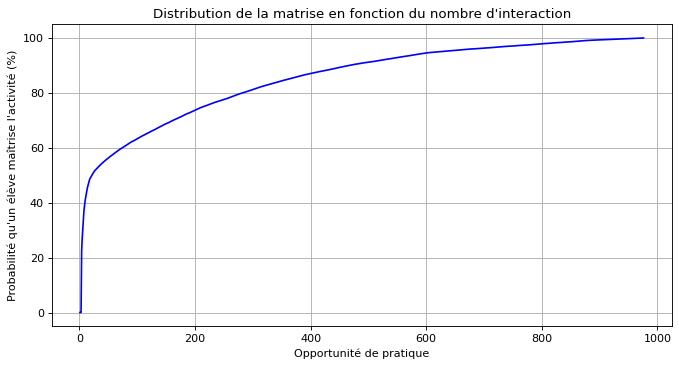

In [23]:
#regroupement par intéraction du nombre de maitrise par éléve
a = df_adfrac.groupby(["interaction_num"]).mastery.sum()

#proportion cumulée de maitrise
b = a.cumsum()*100/a.sum()

#visualisation graphique
plt.figure(dpi = 80, figsize = (10,5))
b.plot(color = "blue")
plt.xlabel("Opportunité de pratique")
plt.ylabel("Probabilité qu'un élève maîtrise l'activité (%)")
plt.title("Distribution de la matrise en fonction du nombre d'interaction")
plt.grid()
plt.show()

Question : est-il crédible de fixer le seuil du wheel-spinning à 10 comme dans les autres papiers ? 
Réponse : Cela n'est pas vraisemblable puisque sur ce graphique, l'insensibilité de variation se perçoit à partir de la 20e interaction approximativement.

Nous fixons donc la limite d'interaction pour définir le WS, sur l'application adaptive fraction, à 20 ! (Nota ce résultat à été observé, sur le tout premier dump de données sur lequel nous avons travaillé)

In [24]:
ws_interact_seuil = 20

Somme toutes, un élève fait du WS sur une activité s'il n'a pas matrisé l'activité au bout de 20 itérations.

Avant de continuer, supprimons déjà toutes les interactions de plus de ce seuil, ici toutes les interactions de num au moins 21 :

In [25]:
data = df_adfrac.drop(df_adfrac[df_adfrac.interaction_num > ws_interact_seuil].index)

Affichons la répartition des élèves en fonction des interactions (un élève peut être compté plusieurs fois) : 

In [26]:
data["interaction_num"].value_counts()

1     4980
2     4908
3     4797
4     4690
5     2439
6     2058
7     1740
8     1497
9     1289
10    1132
11    1002
12     909
13     838
14     782
15     726
16     687
17     655
18     623
19     422
20     396
Name: interaction_num, dtype: int64

<b>Calculons maintenant le wheel-spinning </b> :

Selon le seuil fixé, écartons les apprenants ayant moins de ce seuil et n'ayant pas matrisé l'activité, mais gardons ceux ayant maîtrisé. Les individus supprimés sont les indéterminés

Ensuite, sur les 20 dernières interactions :
    si score moyen sur les quatres derniers exos < success_rate alors WS
    sinon pas WS.

Suppression des indéterminations :

In [27]:
def ws_manage(data, id_eleve, id_activite):
    
    """
    Cette fonction retourne, à partir d'un data frame d'itérations, d'un id d'élève et d'un id d'une activité, 
    le nombre d'interactions et l'état de maîtrise ou non de cette activité par l'élève 
    """
    df = data[(data["student_id"] == id_eleve) & (data["activity_id"] == id_activite)]
    nombre_interaction = df.shape[0]
    master = df["mastery"].sum()
    return id_eleve, id_activite, nombre_interaction, master

Voici un test de la fonction : 

In [28]:
data[((data["student_id"] == "fdc9c7e1-5ae2-4de2-bc90-07fcc0194605") & (data["activity_id"] == "02f48daf-a10c-426f-9855-07c32dc230e5"))]

,student_id,activity_id,ts,heure,duration,score,interaction_num,score_at_inter,mastery
15998,fdc9c7e1-5ae2-4de2-bc90-07fcc0194605,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 02:59:21.672000+00:00,2,6,1.0,1,NaN,NaN
16006,fdc9c7e1-5ae2-4de2-bc90-07fcc0194605,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 02:59:27.599000+00:00,2,4,1.0,2,NaN,NaN
16011,fdc9c7e1-5ae2-4de2-bc90-07fcc0194605,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 02:59:34.883000+00:00,2,5,1.0,3,NaN,NaN
16015,fdc9c7e1-5ae2-4de2-bc90-07fcc0194605,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-12 02:59:39.938000+00:00,2,3,1.0,4,1.0,1.0


In [29]:
ws_manage(data, "fdc9c7e1-5ae2-4de2-bc90-07fcc0194605", "02f48daf-a10c-426f-9855-07c32dc230e5")

('fdc9c7e1-5ae2-4de2-bc90-07fcc0194605',
 '02f48daf-a10c-426f-9855-07c32dc230e5',
 4,
 1.0)

Créons une copie du jeu de données d'interactions manipulé jusqu'à cette étape avant d'écarter les indéterminations :

In [30]:
data_copy = data.copy()

Shape du jeu de données avec indéterminations : 36570 interactions et 9 colonnes

In [31]:
data.shape

(36570, 9)

In [32]:
#suppression des indéterminations

liste_eleve = data["student_id"].unique() #liste des identifiants uniques des élèves
indetermination = [] #création d'une liste vide pour stocker les identifiants qui seront indéterminées

##parcourir pour chaque étudiant la liste des interactions indéterminées et rajouter leur identification sur la liste vide
for eleve in liste_eleve:
    liste_activite = data_copy[data_copy["student_id"] == eleve]["activity_id"].unique()

    for activite in liste_activite:
        infos_eleve = ws_manage(data_copy, eleve, activite)
        if ((infos_eleve[2] < 20) & (infos_eleve[3] == 0)):
            indetermination.append(infos_eleve[0] + infos_eleve[1])
            
##processus de suppression des indéterminations
data_copy["key"] = data_copy["student_id"] + data_copy["activity_id"]
data_copy = data_copy.set_index("key")
data_copy = data_copy.drop(data_copy.loc[indetermination, ].index)
data_copy = data_copy.reset_index()
del data_copy["key"]

Shape du jeu de données sans indéterminations : 33070 interactions et 9 colonnes

In [33]:
data_copy.shape

(33070, 9)

Maintenant que les indéterminations sont écartées, calculons le wheel-spinning :

In [34]:
#création de la colonne wheel-spinning sur chaque interaction élève-activité
data_copy = data_copy.sort_values(by = ['student_id', 'activity_id', 'ts'])
data_copy["key"] = data_copy["student_id"] + data_copy["activity_id"]
data_copy["wheel-spinning"] = None

#calcul du wheel-spinning sur chaque unité élève-activité
w = data_copy.groupby(["student_id", "activity_id"]).agg({"mastery" : "sum"}).reset_index()
w["wheel-spinning"] = np.where(w["mastery"] >= 1, 0, 1)
w["key"] = w["student_id"] + w["activity_id"]

#réplication des résultats du wheel-spinning de chaque unité élève-activité sur l'ensemble des interactions concernées
for key in w["key"].unique():
    data_copy.loc[data_copy["key"] == key, "wheel-spinning"] = w.loc[w["key"] == key, "wheel-spinning"].values[0]

#supression de la colonne de "merge"
del data_copy["key"]

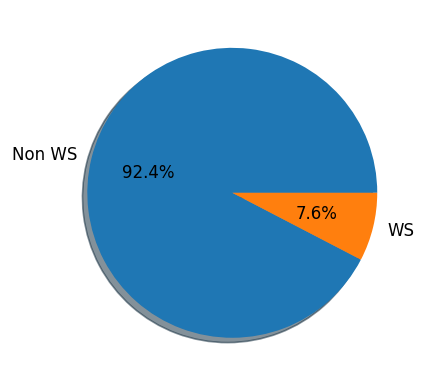

In [35]:
plt.figure(dpi = 120)
labels = ["Non WS", "WS"]
w["wheel-spinning"].value_counts("normalize = True").plot(kind = "pie", autopct='%1.1f%%', shadow=True, labels=labels)
plt.axis('off')
plt.show()
del w

Il y a un déséquilibre du target $\Longrightarrow$ imbalanced binary classification !

In [36]:
#affichons les cinq premières lignes du jeu de données traité
data_copy.head()

,student_id,activity_id,ts,heure,duration,score,interaction_num,score_at_inter,mastery,wheel-spinning
0,009cb4d4-9776-4e66-b657-16b1b542fe83,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-23 03:02:17.471000+00:00,3,53,1.0,1,NaN,NaN,0
1,009cb4d4-9776-4e66-b657-16b1b542fe83,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-23 03:02:39.206000+00:00,3,18,1.0,2,NaN,NaN,0
2,009cb4d4-9776-4e66-b657-16b1b542fe83,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-23 03:03:04.739000+00:00,3,8,1.0,3,NaN,NaN,0
3,009cb4d4-9776-4e66-b657-16b1b542fe83,02f48daf-a10c-426f-9855-07c32dc230e5,2021-07-23 03:04:33.096000+00:00,3,7,1.0,4,1.0,1.0,0
4,009cb4d4-9776-4e66-b657-16b1b542fe83,06949cc0-cbbb-4d18-98ba-a0ba7b255077,2021-07-30 03:28:15.029000+00:00,3,7,1.0,1,NaN,NaN,0


## Prédiction du wheel-spinning

Nous prédisons le Wheel-Spinning, dans ce qui suit, par apprentissage profond. Plus précisement, nous employons des modèles de réseaux de neurones récurrents de type LSTM.

### Préparation des données pour le LSTM

Extraction de la matrice de design $X$ et du vecteur d'étiquette $y$ :

In [37]:
X = data_copy[["heure", "duration", "score"]].values
y = data_copy[["student_id", "activity_id", "wheel-spinning"]].drop_duplicates()["wheel-spinning"].values.astype("float32")

Transformation des données en des séquences d'interactions de longeur 20 :

In [38]:
liste_eleve = list(data_copy["student_id"].unique())
X_sequence = []

for eleve in liste_eleve:
    d = data_copy[(data_copy["student_id"] == eleve)]
    liste_activite = list(d["activity_id"].unique())
    
    for activite in liste_activite:
        d2 = d[d["activity_id"] == activite]
        une_sequence_X = d2[["heure", "duration", "score"]].values
        X_sequence.append(une_sequence_X)

X_seq = pad_sequences(X_sequence, maxlen=20, dtype="float32", padding="post", value = -10.)

Création d'un jeu de données d'entrainement et de test :

In [39]:
poids_test_data = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size = poids_test_data)

Normalisation des features quantitatives :

In [40]:
#train
X_train_copy = np.copy(X_train)
train_reshape = X_train_copy.reshape(-1, X_train.shape[-1])
colonnes = ["col" + str(i) for i in range(1, X_train.shape[2] + 1)]
train_df = pd.DataFrame(train_reshape, columns = colonnes)
train_df_no_mask = train_df[train_df["col1"] != -10]
scaler = StandardScaler()
train_df_no_mask_norm = scaler.fit_transform(train_df_no_mask.values)
train_df.iloc[train_df_no_mask.index,] = train_df_no_mask_norm
X_train = train_df.values.reshape(X_train.shape)

#test
X_test_copy = np.copy(X_test)
test_reshape = X_test_copy.reshape(-1, X_test.shape[-1])
colonnes = ["col" + str(i) for i in range(1, X_test.shape[2] + 1)]
test_df = pd.DataFrame(test_reshape, columns = colonnes)
test_df_no_mask = test_df[test_df["col1"] != -10]
test_df_no_mask_norm = scaler.transform(test_df_no_mask.values)
test_df.iloc[test_df_no_mask.index,] = test_df_no_mask_norm
X_test = test_df.values.reshape(X_test.shape)

### LSTM tunning

Construisons à présent l'architecture de notre réseau de neurones artificiels :

- architecture du modèle de réseaux de neurones artificiels :

In [41]:
def build_model():
    model = Sequential()
    model.add(Masking(mask_value = -10.))
    model.add(LSTM(64, input_shape = (20, 3), return_sequences = True))
    model.add(LSTM(32, return_sequences = False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=["accuracy", Recall(name = "recall"), Precision(name = "precision")])
    return model

- voici un exemple de calcul de l'opérateur LSTM sur un tenseur de nombre notre jeu de données d'entrainement :

In [42]:
lstm_1 = LSTM(64, input_shape = (20, 3), return_sequences = True)
lstm_2 = LSTM(32, return_sequences = False)
dense_binary = Dense(1, activation='sigmoid')
lstm = lstm_2(lstm_1(X_train))
output = dense_binary(lstm)
print("On firt sample of training data \n\nLSTM computing = ", lstm[0], "\n\nOutput =",  output[0])

On firt sample of training data 

LSTM computing =  tf.Tensor(
[-0.05658558 -0.03386578 -0.03490989 -0.00904555  0.00911966 -0.09084429
  0.09134036  0.01396993 -0.04736669 -0.07713458 -0.2457903   0.03558758
 -0.16548383 -0.10256788 -0.01679109  0.11747889 -0.08193975  0.04093007
 -0.08278444 -0.11193979  0.04379886 -0.07520771 -0.08975775 -0.06908397
  0.08603553  0.13573886  0.23615351  0.05114957 -0.00713791  0.04211088
  0.05518506 -0.05135101], shape=(32,), dtype=float32) 

Output = tf.Tensor([0.47343248], shape=(1,), dtype=float32)


- entraînement du réseau par validation croisée de k folds (jeu de données de taille faible)

In [43]:
k = 5

num_val_samples = len(X_train) // k
num_epochs = 300
all_rec_histories = []
all_prec_histories = []
all_acc_histories = []

for i in range(k):
    print(f"Traitement fold #{i} : OK !")
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_X_train = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    weights = {0:1, 1:100}
    history = model.fit(partial_X_train, partial_y_train, epochs = num_epochs, batch_size = 256, class_weight = weights, verbose = 0)
    
    #rec_history = history.history["recall_m"]
    rec_history = history.history["recall"]
    all_rec_histories.append(rec_history)
    
    #prec_history = history.history["precision_m"]
    prec_history = history.history["precision"]
    all_prec_histories.append(prec_history)
    
    acc_history = history.history["accuracy"]
    all_acc_histories.append(acc_history)

Traitement fold #0 : OK !
Traitement fold #1 : OK !
Traitement fold #2 : OK !
Traitement fold #3 : OK !
Traitement fold #4 : OK !


- visualisation du Recall sur les données de validation

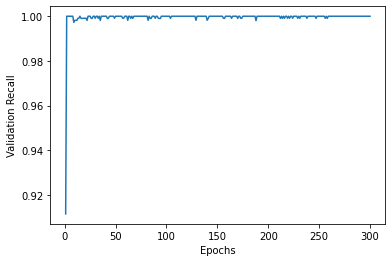

In [44]:
average_rec_history = [np.mean([x[i] for x in all_rec_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_rec_history) + 1), average_rec_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Recall")
plt.show()

- visualisation de la Precision sur les données de validation

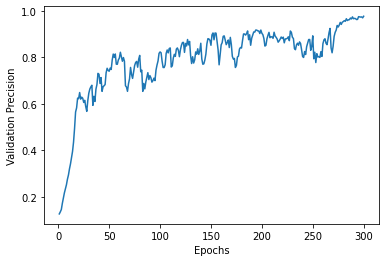

In [45]:
average_prec_history = [np.mean([x[i] for x in all_prec_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_prec_history) + 1), average_prec_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Precision")
plt.show()

- visualisation de l'Accuracy sur les données de validation

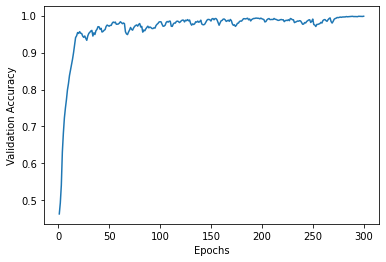

In [46]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

- Etant donnée la nombre de data points et la variance, nous nous proposons de lisser les différentes courbes d'apprentissage :

In [47]:
#fonction de lissage exponentielle
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

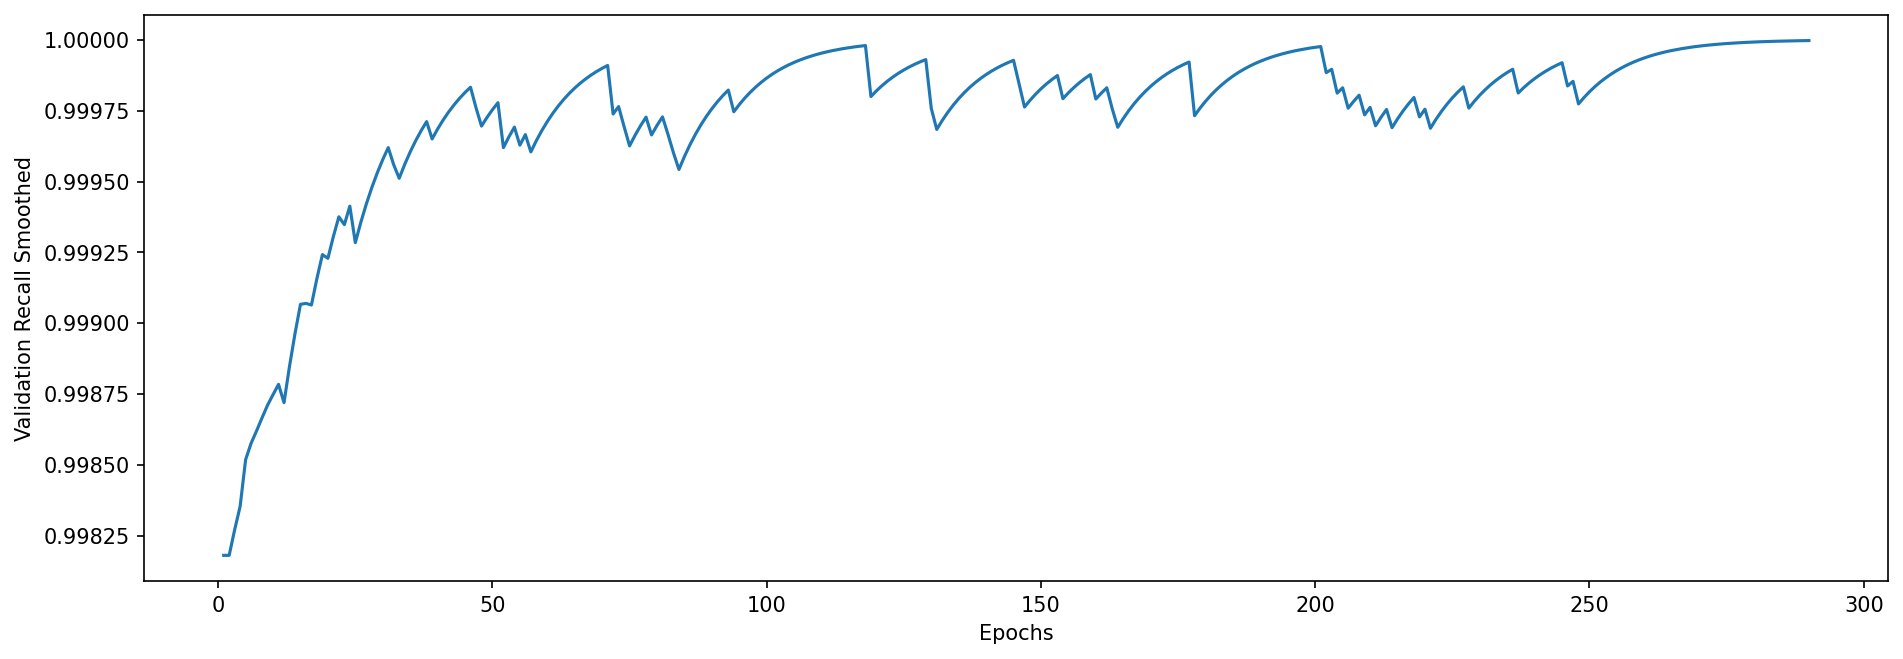

Max :  0.9999972916341147 Epoch :  289


In [48]:
#lissage de la courbe d'apprentissage de Recall
smoothed_rec_history = smooth_curve(average_rec_history[10:])
plt.figure(dpi = 150, figsize = (15,5))
plt.plot(range(1, len(smoothed_rec_history) + 1), smoothed_rec_history)
plt.ylabel("Validation Recall Smoothed")
plt.xlabel("Epochs")
plt.show()
print("Max : ", np.max(smoothed_rec_history), "Epoch : ", np.argmax(smoothed_rec_history))

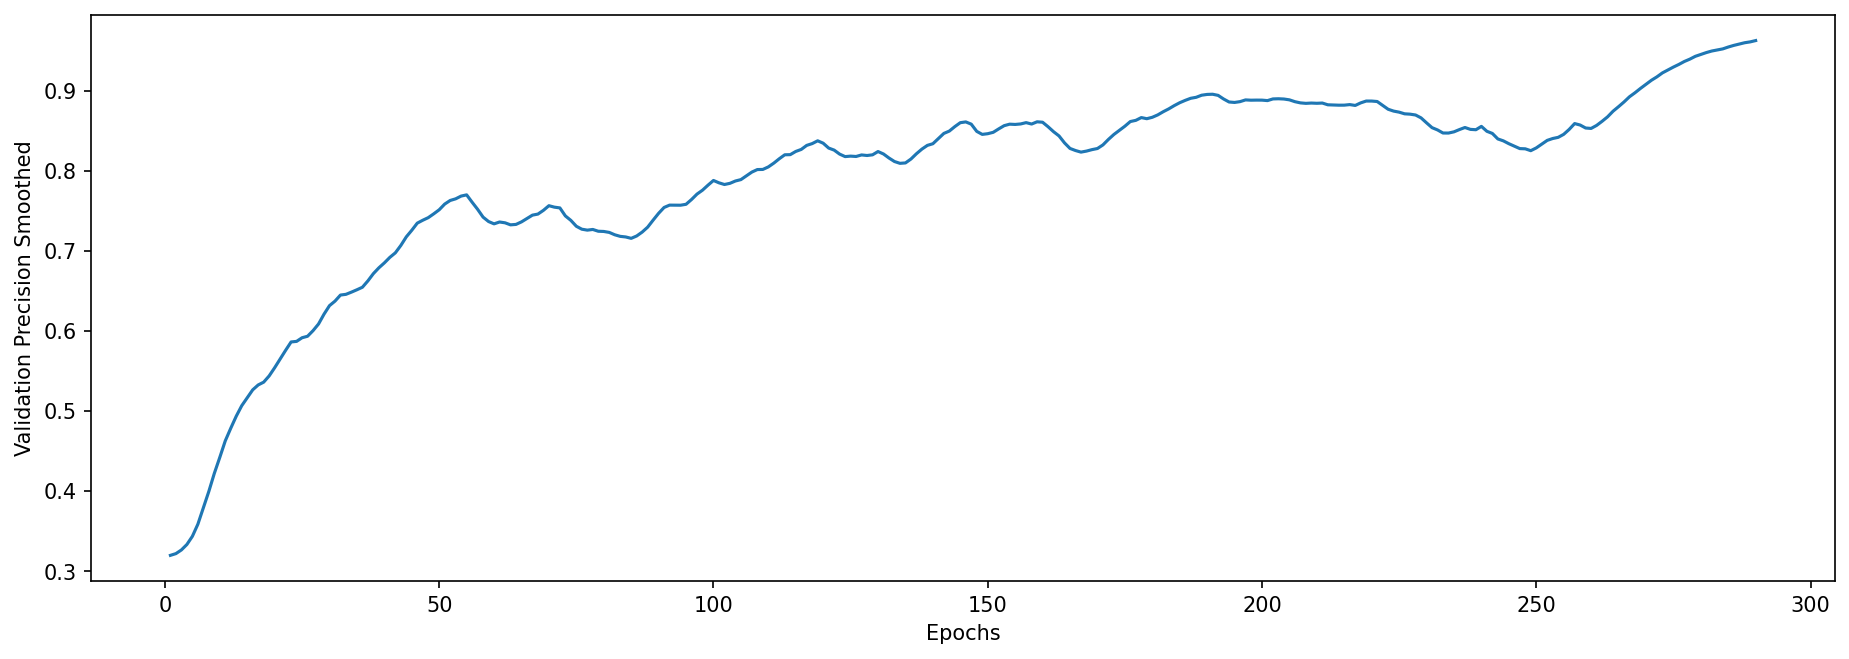

Max :  0.9628349012985001 Epoch :  289


In [49]:
#lissage de la courbe d'apprentissage de la Precision
smoothed_prec_history = smooth_curve(average_prec_history[10:])
plt.figure(dpi = 150, figsize = (15,5))
plt.plot(range(1, len(smoothed_prec_history) + 1), smoothed_prec_history)
plt.ylabel("Validation Precision Smoothed")
plt.xlabel("Epochs")
plt.show()
print("Max : ", np.max(smoothed_prec_history), "Epoch : ", np.argmax(smoothed_prec_history))

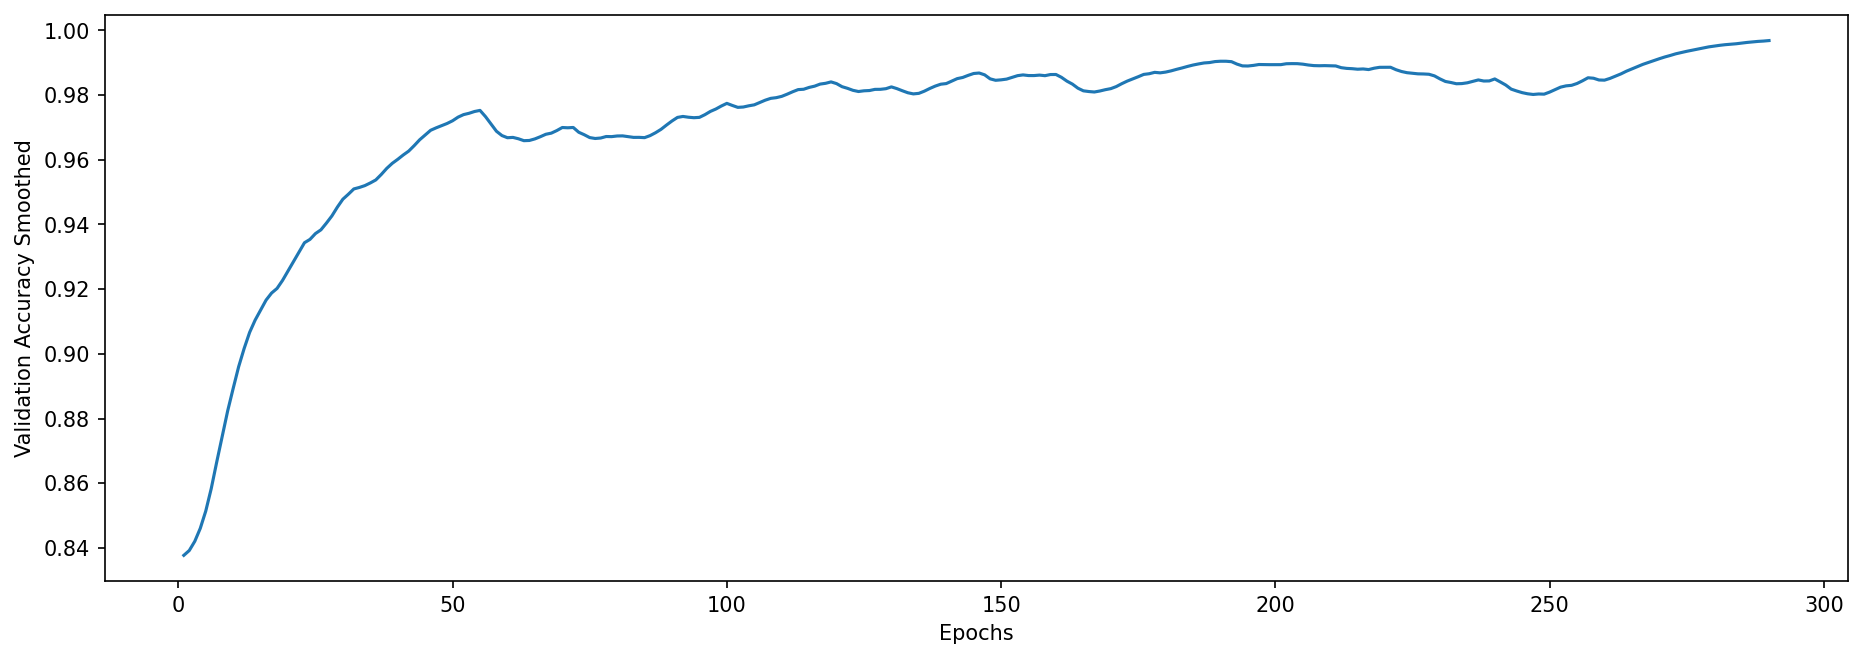

Max :  0.9968740709414611 Epoch :  289


In [50]:
#lissage de la courbe d'apprentissage de l'Accuracy
smoothed_acc_history = smooth_curve(average_acc_history[10:])
plt.figure(dpi = 150, figsize = (15,5))
plt.plot(range(1, len(smoothed_acc_history) + 1), smoothed_acc_history)
plt.ylabel("Validation Accuracy Smoothed")
plt.xlabel("Epochs")
plt.show()
print("Max : ", np.max(smoothed_acc_history), "Epoch : ", np.argmax(smoothed_acc_history))

### Modèle final

In [51]:
opti_epoch = np.argmax(smoothed_prec_history)
model = build_model()
weights = {0:1, 1:100}
model.fit(X_train, y_train, epochs = opti_epoch, batch_size = 256, class_weight = weights, verbose=0)
print("Entrainement terminé !")

Entrainement terminé !


In [52]:
print("Train perf : ", model.evaluate(X_train, y_train))

111/111 [==============================] - 3s 8ms/step - loss: 0.0198 - accuracy: 0.9952 - recall: 1.0000 - precision: 0.9408
Train perf :  [0.019767194986343384, 0.9951896071434021, 1.0, 0.9407665729522705]


## Généralisation du modèle : Evaluation

In [53]:
#Généralisation du modèle
loss, test_acc_score, test_rec_score, test_prec_score = model.evaluate(X_test, y_test)

28/28 [==============================] - 0s 13ms/step - loss: 0.0282 - accuracy: 0.9932 - recall: 0.9851 - precision: 0.9296


In [54]:
#prédiction on test
y_pred = model.predict(X_test)

- Fonctions d'évaluation :

In [55]:
def plot_accuracy(data_type_train = X_train, data_type_label = y_train):
    acc = round(100*model.evaluate(data_type_train, data_type_label, verbose = 0)[1], 2)
    plt.text(0.75, 0.65, str(acc) + "%" , size = 50, rotation=0,
             ha="right", va="top",
             bbox=dict(boxstyle="square",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )
    plt.axis("off")
    plt.title("Accuracy  :")
    return plt.show()
    
def confusion_matrix_nn(prediction = model.predict(X_train), true_label = y_train, threshold = 0.5):  
    
    prediction_class = np.where(prediction > threshold, 1, 0)
    a = true_label
    b = prediction_class

    cf_matrix = confusion_matrix(a, b)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize = (7,5), dpi = 80)
    sns.heatmap(cf_matrix, annot = labels, fmt = "", cmap = 'Blues')
    plt.xlabel("Prédictions")
    plt.ylabel("Réels")
    plt.title("Matrice de confusion")
    
    return plt.show()


def roc_curve_nn(prediction = model.predict(X_train), true_label = y_train):
    
    a = true_label
    b = prediction.ravel()
    
    nn_fpr_keras, nn_tpr_keras, thresholds_1 = roc_curve(a, b)
    auc_keras = auc(nn_fpr_keras, nn_tpr_keras)

    plt.figure(dpi = 80, figsize = (7,5))
    plt.plot(nn_fpr_keras, nn_tpr_keras, marker = '*', label='LSTM (AUC = %0.3f)' % auc_keras)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Courbe ROC")
    plt.legend()
    plt.grid()
    return plt.show()

def precision_recall_curve_nn(prediction = model.predict(X_train), true_label = y_train):
    
    a = true_label
    b = prediction.ravel()
    nn_r_keras, nn_pr_keras, thresholds_2 = precision_recall_curve(a, b)
    
    ap_keras = average_precision_score(a, b)
    plt.figure(dpi = 80, figsize = (7,5))
    plt.plot(nn_r_keras, nn_pr_keras, marker = '.', label='LSTM (Average Precision = %0.3f)' % ap_keras)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Courbe Précision-Rappel")
    plt.legend()
    plt.grid()
    return plt.show()

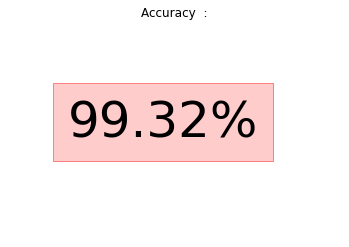

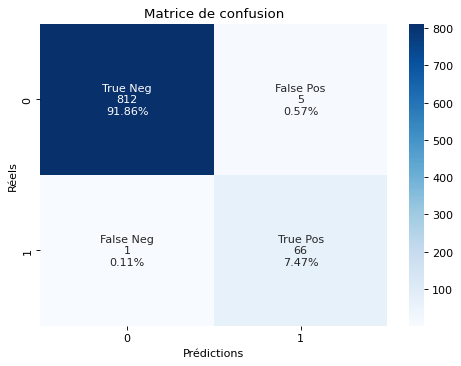

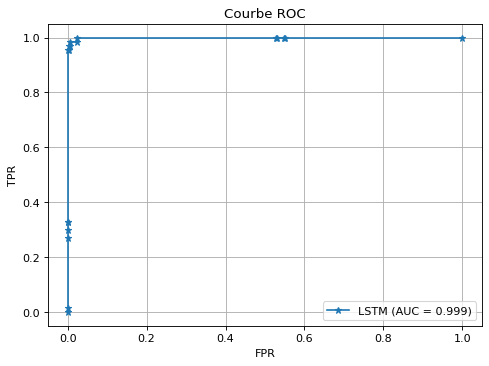

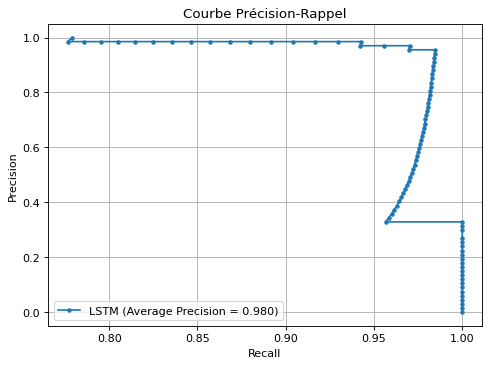

In [56]:
#matrice de confusion, courbe roc et courbe précision rappel sur le test
plot_accuracy(X_test, y_test)
confusion_matrix_nn(y_pred, y_test)
roc_curve_nn(y_pred, y_test)
precision_recall_curve_nn(y_pred, y_test)

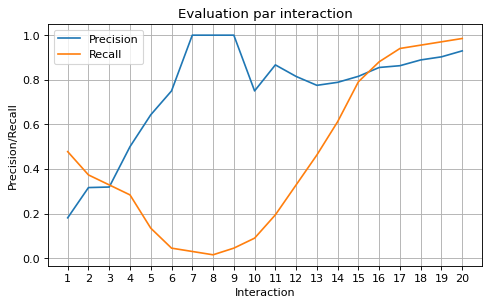

In [57]:
# Evaluation du modèle par interaction
#------------------------------------------------------------------------

precision = []
recall = []
threshold = 0.5
a = y_test

for trunc in range(1,21):
    
    X_test_trunc = X_test[:, :trunc, :]
    X_test_trunc_pad = pad_sequences(X_test_trunc, maxlen=20, dtype="float32", value = -10., padding="post")

    y_pred_trunc = model.predict(X_test_trunc_pad)
    y_pred_trunc_class = np.where(y_pred_trunc > threshold, 1, 0)

    b = y_pred_trunc_class
    precision.append(precision_score(a,b))
    recall.append(recall_score(a,b))
        
x = np.array(list(range(1,21)))
y1 = np.array(precision)
y2 = np.array(recall)

plt.figure(dpi = 80, figsize = (7,4))
plt.plot(x , y1, label = "Precision")
plt.plot(x , y2, label = "Recall")
plt.xlabel("Interaction")
plt.ylabel("Precision/Recall")
plt.title("Evaluation par interaction")
plt.xticks(range(1,21))
plt.grid()
plt.legend()
plt.show() 